### 데이터 로더

In [3]:
import os
import json
import random
from tqdm import tqdm
import numpy as np
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rc
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.models as models
from torch.utils.data import DataLoader, Subset

class DriverMonitoringDataset(Dataset):
    def __init__(self, img_root_dir, label_root_dir, transform=None):
        self.img_root_dir = img_root_dir
        self.label_root_dir = label_root_dir
        self.transform = transform
        self.data = self.load_data()
        self.class_to_idx = self.build_class_indices()

    def load_data(self):
        data = []
        for sga_folder in os.listdir(self.img_root_dir):
            ts_img_path = os.path.join(self.img_root_dir, sga_folder)
            ts_label_path = os.path.join(self.label_root_dir, sga_folder)
            
            if os.path.isdir(ts_img_path) and os.path.isdir(ts_label_path):
                for scenario_folder in os.listdir(ts_img_path):
                    img_scenario_path = os.path.join(ts_img_path, scenario_folder, 'img')
                    label_scenario_path = os.path.join(ts_label_path, scenario_folder, 'label')

                    if not os.path.exists(label_scenario_path) or not os.path.exists(img_scenario_path):
                        print(f"Missing label or image folder for scenario: {scenario_folder}")
                        continue

                    for label_file in os.listdir(label_scenario_path):
                        if label_file.endswith('.json'):
                            with open(os.path.join(label_scenario_path, label_file), 'r', encoding='utf-8') as f:
                                try:
                                    label_data = json.load(f)
                                except json.JSONDecodeError:
                                    print(f"Error reading JSON file: {label_file}")
                                    continue
                                
                                if 'scene' not in label_data or 'data' not in label_data['scene']:
                                    print(f"Invalid label data structure in: {label_file}")
                                    continue
                                
                                for img_data in label_data['scene']['data']:
                                    img_name = img_data['img_name']
                                    img_path = os.path.join(img_scenario_path, img_name)
                                    if os.path.exists(img_path):
                                        data.append((img_path, img_data))
                                    else:
                                        print(f"Image file not found: {img_path}")
            else:
                print(f"SGA folder not found or is not a directory: {sga_folder}")
        print(f"Total data loaded: {len(data)} samples")
        return data

    def build_class_indices(self):
        class_to_idx = {}
        for _, img_data in self.data:
            action = img_data['occupant'][0]['action']
            if action not in class_to_idx:
                class_to_idx[action] = len(class_to_idx)
        return class_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, img_data = self.data[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            
            action = img_data['occupant'][0]['action']
            label = self.class_to_idx[action]
            return image, label
        except UnidentifiedImageError:
            print(f"Skipping corrupted image: {img_path}")
            return None, None

def custom_collate_fn(batch):
    # None 요소 제거
    batch = [data for data in batch if data[0] is not None]
    if not batch:
        return torch.empty(0, 3, 224, 224), torch.empty(0, dtype=torch.long)
    return torch.utils.data.default_collate(batch)

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 데이터셋 및 데이터 로더 설정
img_root_dir = r"Z:\ABCLab\2. Personal\이다솜\SW경진대회_2024\운전자데이터\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\1.Training\원천데이터\abnormal_230303_add\TS1"
label_root_dir = r"Z:\ABCLab\2. Personal\이다솜\SW경진대회_2024\운전자데이터\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\1.Training\라벨링데이터\abnormal_230303_add\TL1"
dataset = DriverMonitoringDataset(img_root_dir=img_root_dir, label_root_dir=label_root_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn, pin_memory=True)

Missing label or image folder for scenario: SGA2100198S0225
Missing label or image folder for scenario: SGA2100006S0091
Image file not found: Z:\ABCLab\2. Personal\이다솜\SW경진대회_2024\운전자데이터\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\1.Training\원천데이터\abnormal_230303_add\TS1\SGA2100005\SGA2100005S0366\img\SGA2100005S0366IMG0001.jpg
Image file not found: Z:\ABCLab\2. Personal\이다솜\SW경진대회_2024\운전자데이터\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\1.Training\원천데이터\abnormal_230303_add\TS1\SGA2100005\SGA2100005S0366\img\SGA2100005S0366IMG0002.jpg
Image file not found: Z:\ABCLab\2. Personal\이다솜\SW경진대회_2024\운전자데이터\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\1.Training\원천데이터\abnormal_230303_add\TS1\SGA2100005\SGA2100005S0366\img\SGA2100005S0366IMG0003.jpg
Image file not found: Z:\ABCLab\2. Personal\이다솜\SW경진대회_2024\운전자데이터\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\1.Training\원천데이터\abnormal_230303_add\TS1\SGA2100005\SGA2100005S0366\img\SGA2100005S0366IMG0004.jpg
Image file not found: Z:\ABCLab\2. Personal\이다솜\SW경진대회_2024\운전자데이터\089.차량 내 탑승자 상황 인

### 데이터 확인

In [5]:
# 데이터 로더에서 하나의 배치를 가져옵니다.
images, labels = next(iter(data_loader))

# 첫 번째 이미지와 라벨 출력
print(f"Batch size: {images.size()}")
print(f"First label: {labels[0]}")


Batch size: torch.Size([32, 3, 224, 224])
First label: 0


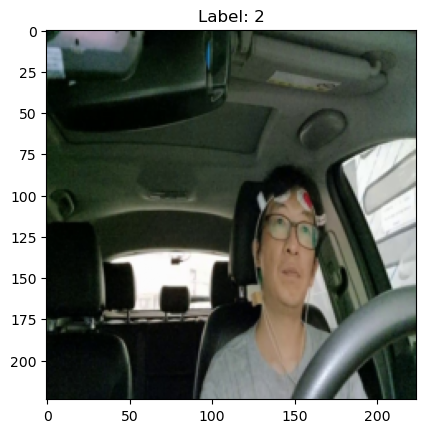

{'운전하다': 0, '무언가를보다': 1, '몸을돌리다': 2, '창문을열다': 3, '무언가를쥐다': 4, '무언가를마시다': 5, '허리굽히다': 6, '손을뻗다': 7, '핸들을흔들다': 8, '몸못가누기': 9, '중앙을쳐다보다': 10, '핸드폰쥐기': 11, '고개를돌리다': 12, '힐끗거리다': 13, '핸드폰귀에대기': 14, '중앙으로손을뻗다': 15, '옆으로기대다': 16, '꾸벅꾸벅졸다': 17, '핸들을놓치다': 18, '박수치다': 19, '뺨을때리다': 20, '눈비비기': 21, '목을만지다': 22, '하품': 23, '팔주무르기': 24, '눈깜빡이기': 25, '어깨를두드리다': 26, '고개를좌우로흔들다': 27, '허벅지두드리기': 28}
Index: 2, Action: 몸을돌리다


In [6]:
# 데이터 로더에서 하나의 배치를 가져옵니다.
images, labels = next(iter(data_loader))

# 첫 번째 이미지와 라벨 출력
plt.imshow(images[0].permute(1, 2, 0))
plt.title(f"Label: {labels[0].item()}")
plt.show()

# class_to_idx 내용 확인
print(dataset.class_to_idx)

# 첫 번째 이미지와 라벨 출력
first_label = labels[0].item()
print(f"Index: {first_label}, Action: {list(dataset.class_to_idx.keys())[first_label]}")



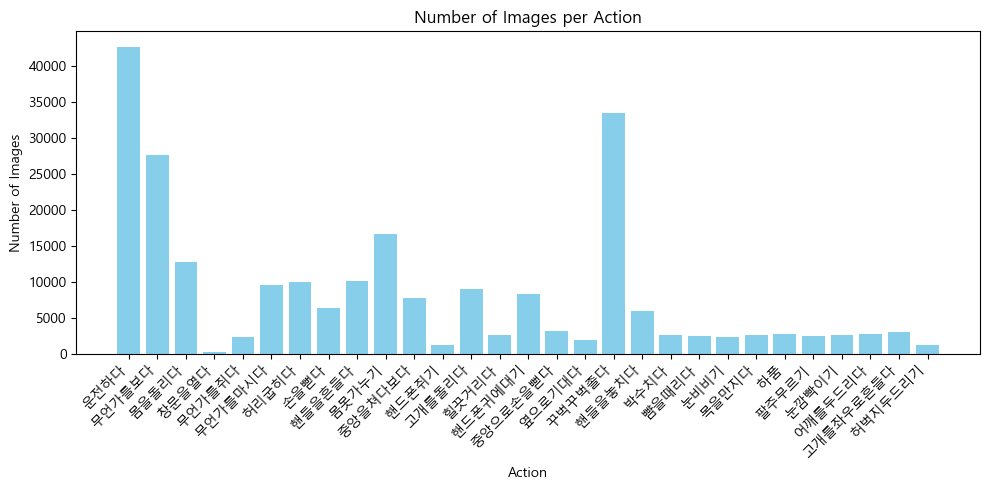

In [6]:
# 사용할 폰트 지정 (Windows의 경우 예: 'Malgun Gothic')
font_path = 'C:/Windows/Fonts/malgun.ttf'

# 폰트 설정
font_name = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 데이터셋에서 각 액션별 이미지 수 집계
class_counts = {class_name: 0 for class_name in dataset.class_to_idx.keys()}
for _, img_data in dataset.data:
    action = img_data['occupant'][0]['action']
    class_counts[action] += 1

# 클래스 이름과 해당 이미지 수 리스트로 분리
actions = list(class_counts.keys())
counts = list(class_counts.values())

# 막대 그래프 생성
plt.figure(figsize=(10, 5))
plt.bar(actions, counts, color='skyblue')
plt.xlabel('Action')
plt.ylabel('Number of Images')
plt.title('Number of Images per Action')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 연결 끊길 시, 로드된 데이터셋 불러오기

In [15]:
# 데이터셋 저장 코드

import pickle
pkl_path = 'Z:/ABCLab/2. Personal/이다솜/SW경진대회_2024/data.pkl'
with open(pkl_path, 'wb') as f:
    pickle.dump(dataset, f)

In [5]:
# 데이터셋 불러오는 코드

import torch
import pickle

# DriverMonitoringDataset 클래스 정의
class DriverMonitoringDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 데이터 로드
with open('Z:/ABCLab/2. Personal/이다솜/SW경진대회_2024/data.pkl', 'rb') as f:
    dataset = pickle.load(f)

print("Dataset loaded successfully.")

Dataset loaded successfully.


### VGGNet16으로 이미지 분류 학습

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import os
import random
import numpy as np
from PIL import UnidentifiedImageError

# 랜덤 시드 고정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# 데이터셋 및 학습 설정
total_size = len(dataset)
num_splits = 10  # 10개의 서브샘플로 나누기
num_classes = len(dataset.class_to_idx)
num_epochs = 5
batch_size = 32
learning_rate = 0.0005
print_interval = 100
checkpoint_dir = 'Z:/ABCLab/2. Personal/이다솜/SW경진대회_2024'
os.makedirs(checkpoint_dir, exist_ok=True)
print("Checkpoint directory created.")

# GPU 사용 여부 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 초기화 및 설정
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 설정: 시작할 서브셋과 에포크
start_split = 0  # 0-indexed, 예: 1은 두 번째 서브셋을 의미
start_epoch = 0  # 0-indexed, 예: 0은 첫 번째 에포크를 의미

# 체크포인트 불러오기 - subset_1_epoch_5.pth
# checkpoint_path = os.path.join(checkpoint_dir, 'subset_1_epoch_5_checkpoint.pth')
# if os.path.exists(checkpoint_path):
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     print(f"Loaded checkpoint from {checkpoint_path}")

# 데이터셋을 10등분하여 학습
for split_index in range(start_split, num_splits):
    # 서브셈플링 인덱스 설정
    indices = list(range(total_size))
    random.shuffle(indices)
    split_size = total_size // num_splits
    subset_indices = indices[split_index * split_size:(split_index + 1) * split_size]
    subset = Subset(dataset, subset_indices)

    # custom_collate_fn 정의
    def custom_collate_fn(batch):
        batch = [item for item in batch if item[0] is not None]
        if not batch:
            return torch.empty(0, 3, 224, 224), torch.empty(0, dtype=torch.long)
        return torch.utils.data.default_collate(batch)

    # 데이터 로더 설정
    data_loader = DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, collate_fn=custom_collate_fn)
    print(f"\nStarting training for subset {split_index + 1}/{num_splits}...")

    # 학습 루프
    for epoch in range(start_epoch if split_index == start_split else 0, num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs} for subset {split_index + 1}...")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch + 1} Progress")):
            try:
                images = images.to(device)
                labels = labels.to(device)
                
                # 예측 및 손실 계산
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # 역전파 및 최적화
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # 통계 업데이트
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # 각 배치마다의 loss와 accuracy 출력
                if (batch_idx + 1) % print_interval == 0:
                    batch_loss = loss.item()
                    batch_acc = (predicted.eq(labels).sum().item() / labels.size(0))
                    print(f"[Batch {batch_idx + 1}/{len(data_loader)}] Batch Loss: {batch_loss:.4f}, Batch Accuracy: {batch_acc:.4f}")
            except UnidentifiedImageError as e:
                print(f"Skipping corrupted image: {e}")
                pass
            except Exception as e:
                print(f"Unexpected error: {e}")
                pass

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f'Epoch {epoch + 1} for subset {split_index + 1} complete. Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        # 체크포인트 저장
        checkpoint_path = os.path.join(checkpoint_dir, f'subset_{split_index + 1}_epoch_{epoch + 1}_checkpoint.pth')
        torch.save({
            'subset': split_index + 1,
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_acc
        }, checkpoint_path)
        print(f'Checkpoint saved at {checkpoint_path}')

    start_epoch = 0  # 다음 서브셋으로 넘어갈 때 에포크를 0으로 리셋
    print(f"Training for subset {split_index + 1}/{num_splits} completed.")
print("All subsets training completed.")


### loss, accuracy 그래프 확인

In [4]:
import torch
import os
import matplotlib.pyplot as plt

checkpoint_dir = 'Z:/ABCLab/2. Personal/이다솜\SW경진대회_2024/'
num_splits = 10
num_epochs = 5

# Loss와 Accuracy를 저장할 리스트
loss_list = []
accuracy_list = []

# 각 체크포인트에서 데이터 추출
for split_index in range(num_splits):
    for epoch in range(num_epochs):
        checkpoint_path = os.path.join(checkpoint_dir, f'subset_{split_index + 1}_epoch_{epoch + 1}_checkpoint.pth')
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            loss_list.append(checkpoint['loss'])
            accuracy_list.append(checkpoint['accuracy'])
            print(loss_list)
            print(accuracy_list)

# 손실(Loss) 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_list) + 1), loss_list, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# 정확도(Accuracy) 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()


[2.871076231163089]
[0.17210084033613446]
[2.871076231163089, 2.8482575154504857]
[0.17210084033613446, 0.17478991596638654]
[2.871076231163089, 2.8482575154504857, 2.8465706907801267]
[0.17210084033613446, 0.17478991596638654, 0.1738655462184874]
[2.871076231163089, 2.8482575154504857, 2.8465706907801267, 2.8455455834524974]
[0.17210084033613446, 0.17478991596638654, 0.1738655462184874, 0.17436974789915966]
[2.871076231163089, 2.8482575154504857, 2.8465706907801267, 2.8455455834524974, 2.8449052817080203]
[0.17210084033613446, 0.17478991596638654, 0.1738655462184874, 0.17436974789915966, 0.17495798319327732]
[2.871076231163089, 2.8482575154504857, 2.8465706907801267, 2.8455455834524974, 2.8449052817080203, 2.836207199337102]
[0.17210084033613446, 0.17478991596638654, 0.1738655462184874, 0.17436974789915966, 0.17495798319327732, 0.17915966386554621]
[2.871076231163089, 2.8482575154504857, 2.8465706907801267, 2.8455455834524974, 2.8449052817080203, 2.836207199337102, 2.8358303496416877]

EOFError: Ran out of input

In [11]:
# 오류난 뒤 다시 가져옴
loss_list_2 = [2.871076231163089, 2.8482575154504857, 2.8465706907801267, 2.8455455834524974, 2.8449052817080203, 2.836207199337102, 2.8358303496416877, 2.83533555519681, 2.834623070724872, 2.8344384705519476, 2.8438791343144008, 2.84420030473661, 2.8440471483278675, 2.8433591774531775, 2.8433515535883545, 2.829446980390104, 2.8301140487261685, 2.828998508460983, 2.829031897941614, 2.8298943586031715, 2.833054358440566, 2.8356554599569623, 2.836764186169921, 2.836133239730066, 2.8363060713215034, 2.831255408936188, 2.8315793337140764, 2.832282490850497, 2.831460351062422, 2.831619990052295, 2.8438168823017795, 2.844432486125401, 2.8441309432823116, 2.8439579520506015, 2.8433373783015403, 2.8326795421942395, 2.867004886595141]
accuracy_list_2 = [0.17210084033613446, 0.17478991596638654, 0.1738655462184874, 0.17436974789915966, 0.17495798319327732, 0.17915966386554621, 0.1795798319327731, 0.17911764705882352, 0.17983193277310924, 0.17941176470588235, 0.17941176470588235, 0.17941176470588235, 0.17949579831932774, 0.17936974789915966, 0.1795378151260504, 0.18114206479263834, 0.18105802764822052, 0.18105802764822052, 0.1810160090760116, 0.18105802764822052, 0.18110004622042944, 0.18, 0.1799579831932773, 0.17991596638655463, 0.1799579831932773, 0.17936974789915966, 0.17936974789915966, 0.17911764705882352, 0.17936974789915966, 0.1792857142857143, 0.17915966386554621, 0.17911764705882352, 0.17915966386554621, 0.17915966386554621, 0.17915966386554621, 0.18374721626959115, 0.17798319327731094]

print(len(loss_list_2))
print(len(accuracy_list_2))

37
37


10,5 [2.871076231163089, 2.8482575154504857, 2.8465706907801267, 2.8455455834524974, 2.8449052817080203, 2.836207199337102, 2.8358303496416877, 2.83533555519681, 2.834623070724872, 2.8344384705519476, 2.8438791343144008, 2.84420030473661, 2.8440471483278675, 2.8433591774531775, 2.8433515535883545, 2.829446980390104, 2.8301140487261685, 2.828998508460983, 2.829031897941614, 2.8298943586031715, 2.833054358440566, 2.8356554599569623, 2.836764186169921, 2.836133239730066, 2.8363060713215034, 2.831255408936188, 2.8315793337140764, 2.832282490850497, 2.831460351062422, 2.831619990052295, 2.8438168823017795, 2.844432486125401, 2.8441309432823116, 2.8439579520506015, 2.8433373783015403, 2.8326795421942395, 2.867004886595141, 2.8336227162144767]
[0.17210084033613446, 0.17478991596638654, 0.1738655462184874, 0.17436974789915966, 0.17495798319327732, 0.17915966386554621, 0.1795798319327731, 0.17911764705882352, 0.17983193277310924, 0.17941176470588235, 0.17941176470588235, 0.17941176470588235, 0.

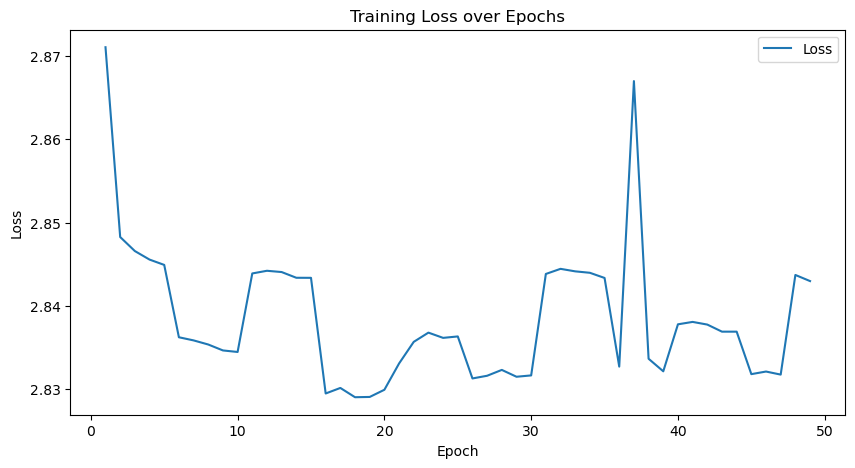

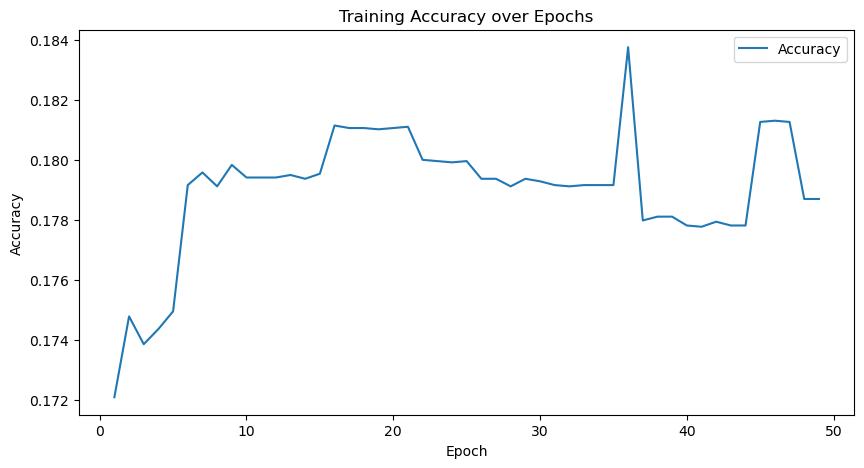

In [13]:
checkpath_list = ['Z:/ABCLab/2. Personal/이다솜\SW경진대회_2024/subset_8_epoch_4_checkpoint.pth',
                 'Z:/ABCLab/2. Personal/이다솜\SW경진대회_2024/subset_8_epoch_5_checkpoint.pth',
                 'Z:/ABCLab/2. Personal/이다솜\SW경진대회_2024/subset_9_epoch_1_checkpoint.pth',
                 'Z:/ABCLab/2. Personal/이다솜\SW경진대회_2024/subset_9_epoch_2_checkpoint.pth',
                 'Z:/ABCLab/2. Personal/이다솜\SW경진대회_2024/subset_9_epoch_3_checkpoint.pth',
                 'Z:/ABCLab/2. Personal/이다솜\SW경진대회_2024/subset_9_epoch_4_checkpoint.pth',
                 'Z:/ABCLab/2. Personal/이다솜\SW경진대회_2024/subset_9_epoch_4_checkpoint.pth',
                 'Z:/ABCLab/2. Personal/이다솜\SW경진대회_2024/subset_10_epoch_1_checkpoint.pth',
                 'Z:/ABCLab/2. Personal/이다솜\SW경진대회_2024/subset_10_epoch_2_checkpoint.pth',
                 'Z:/ABCLab/2. Personal/이다솜\SW경진대회_2024/subset_10_epoch_3_checkpoint.pth',
                 'Z:/ABCLab/2. Personal/이다솜\SW경진대회_2024/subset_10_epoch_4_checkpoint.pth',
                 'Z:/ABCLab/2. Personal/이다솜\SW경진대회_2024/subset_10_epoch_5_checkpoint.pth',]
for checkpoint_path in checkpath_list :
    checkpoint = torch.load(checkpoint_path)
    loss_list_2.append(checkpoint['loss'])
    accuracy_list_2.append(checkpoint['accuracy'])
    print(f"{split_index+1},{epoch+1}",loss_list_2)
    print(accuracy_list_2)
    print()
            
# 손실(Loss) 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_list_2) + 1), loss_list_2, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# 정확도(Accuracy) 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_list_2) + 1), accuracy_list_2, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()